In [56]:
# Bybitが提供している公式のライブラリを用いる
# 使い方は以下のURL参照
# https://bybit-exchange.github.io/docs/linear/#t-constructingtherequest
import bybit
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd

%matplotlib inline

In [57]:
# Bybit API Key (test net)
api_key = "your API key"
api_secret = "your secret key"


# クラスのインスタンス化
# Bybitにはdemo用のtest環境と取引用の本番環境の2種類があり、それぞれでAPI_keyが異なる
# test = Trueにすることでdemo用環境を指定できる

client = bybit.bybit(test=True, api_key = api_key, api_secret = api_secret)

In [58]:
# ローソク足データを取得する 取得できるのは一度に最大200件まで
# 取得したいデータの期間 ここで指定した日時から最大200件のローソク足データが手に入る
date_str = '2021/9/1 00:00'
date_dt = datetime.strptime(date_str, '%Y/%m/%d %H:%M')
target_unix = date_dt.timestamp()
print(target_unix)

1630422000.0


In [59]:
# ローソク足の時間足はintervalで指定 60 = 1時間足
# 1時間足以外に1分足から日足 月足 色々ある　詳細は公式github参照
# 取得したいデータの期間をunix時間で指定しないといけないことがやや面倒

Historical_data = client.Kline.Kline_get(
    symbol="BTCUSD",interval="60", **{'from': target_unix}).result()

# 返り値のparameter
id: 多分データ管理用に割り振られた番号　そんな重要じゃなさそう
'ret_code': 0, 'ret_msg': 'OK', 'ext_code': '', 'ext_info これらはAPIリクエストが成功したかどうかのメッセージ

データはresult以降に格納されている
以下 result内部のparameterについて

symbol: 取引ペア

period: 時間足

start_at, open_time: 時間 unix timeで入ってる startとopenでどう違うのかは不明

open,high,low,close: 始値,高値,安値,終値

volume: 取引数量

turnover: ? 売り上げという意味らしいがvolumeと何が違うのか不明

time_now:　プログラムを実行したときのunix時間

In [60]:
# resultだけを取ってくる
Data = Historical_data[0]['result']

In [61]:
Date = []
Close_price = []
Open_price = []
High_price = []
Low_price = []
Volume = []
for i in range(len(Data)):
    Date.append(datetime.fromtimestamp(Data[i]['open_time']))
    Close_price.append(Data[i]['close'])
    Open_price.append(Data[i]['open'])
    High_price.append(Data[i]['high'])
    Low_price.append(Data[i]['low'])
    Volume.append(Data[i]['volume'])

    
# pandas dataframeを作成
df = pd.DataFrame({     'date' : Date,
                        'open' : Open_price,
                        'high' : High_price,
                        'low' : Low_price,
                        'close' : Close_price,
                        'volume' : Volume })

df = df.set_index('date')
df.head()

,open,high,low,close,volume
date,,,,,
2021-09-01 00:00:00,47322,47462,47222,47453.5,52644132
2021-09-01 01:00:00,47453.5,47592,47337,47384,35559825
2021-09-01 02:00:00,47384,47434,47014,47144,59821725
2021-09-01 03:00:00,47144,47384.5,47063.5,47328,50211046
2021-09-01 04:00:00,47328,47391.5,47244,47339,55550233


Text(0.5, 1.0, 'BTC price change in Bybit')

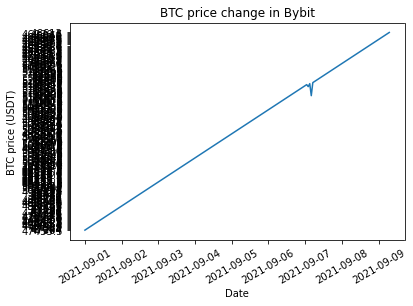

In [62]:
plt.plot(df.index, df['close'])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('BTC price (USDT)')
plt.title('BTC price change in Bybit')

In [63]:
# ローソク足の表示 なんか色々動かせて超便利

fig = go.Figure(data=[go.Candlestick(
                        x=df.index,
                        open=df['open'],
                        high=df['high'],
                        low=df['low'],
                        close=df['close'],
                        increasing_line_color= 'darkgreen',
                        decreasing_line_color= 'red')])

fig.update_layout(autosize=True,width=1000,height=800)
fig

## Liquidation 清算データ
最大で1000件取得できる
start time, end time で取得したい期間を指定できる

返り値の qty が清算注文量を表す単位はドル


In [64]:
Liquidation = client.Market.Market_liqRecords(symbol="BTCUSD").result()

In [65]:
Liquidation_data = Liquidation[0]["result"]

Date_liquid_buy = []
Date_liquid_sell = []
qty_buy = []
qty_sell = []
price_buy = []
price_sell = []

for i in range(len(Data)):
    if Liquidation_data[i]["side"] == "Buy":
        Date_liquid_buy.append(datetime.fromtimestamp(Liquidation_data[i]['time']/1000.0))
        qty_buy.append(Liquidation_data[i]['qty'])
        price_buy.append(Liquidation_data[i]['price'])
    else:
        Date_liquid_sell.append(datetime.fromtimestamp(Liquidation_data[i]['time']/1000.0))
        qty_sell.append(Liquidation_data[i]['qty'])
        price_sell.append(Liquidation_data[i]['price'])
    

In [66]:
print(Liquidation_data[0]['time'])
print(datetime.fromtimestamp(Liquidation_data[0]['time']/1000.0))

1630795147486
2021-09-05 07:39:07.486000


In [67]:
df_liquid_buy = pd.DataFrame({'date' : Date_liquid_buy,
                        'qty_buy' : qty_buy,
                        'price_buy' : price_buy,
                        })

df_liquid_sell = pd.DataFrame({'date' : Date_liquid_sell,
                        'qty_sell' : qty_sell,
                        'price_sell' : price_sell,
                        })


#df_liquid = df_liquid.set_index('date')
df_liquid_sell.head()

,date,qty_sell,price_sell
0,2021-09-05 16:21:24.337,727951,50304.5
1,2021-09-05 23:10:38.436,236177,50613.0
2,2021-09-05 23:15:35.483,103280,50670.5
3,2021-09-06 04:13:30.490,100,50799.5
4,2021-09-06 04:13:31.481,231138,50801.0


In [68]:
df_liquid_buy = df_liquid_buy.groupby(pd.Grouper(key='date', freq='1h')).sum()
df_liquid_sell = df_liquid_sell.groupby(pd.Grouper(key='date', freq='1h')).sum()
df_liquid_sell.head()

,qty_sell,price_sell
date,,
2021-09-05 16:00:00,727951,50304.5
2021-09-05 17:00:00,0,0.0
2021-09-05 18:00:00,0,0.0
2021-09-05 19:00:00,0,0.0
2021-09-05 20:00:00,0,0.0


## Open Interest  未約定ポジション数
最大200件取得可能
なぜかこれだけ古-新でなく新-古の順でデータが返ってくる

In [69]:
OpenInterest = client.Market.Market_openInterest(
    symbol="BTCUSD", limit=200, period="1h"
).result()


In [70]:
OpenInterest_data = OpenInterest[0]["result"]

print(len(OpenInterest_data))

200


In [71]:
Date_open = []
open_interest = []

for i in range(len(Data)):
    Date_open.append(datetime.fromtimestamp(OpenInterest_data[i]['timestamp']))
    open_interest.append(OpenInterest_data[i]['open_interest'])
    

In [72]:
df_open = pd.DataFrame({     'date' : Date_open[::-1],
                        'open_interest' : open_interest[::-1],
                        })

df_open = df_open.set_index('date')
df_open.head()

,open_interest
date,
2021-09-03 21:00:00,235752469
2021-09-03 22:00:00,209091900
2021-09-03 23:00:00,230296393
2021-09-04 00:00:00,233494711
2021-09-04 01:00:00,230893837


OHLCV, OpenInterest, Liquidationデータはそれぞれ取得できる限度が異なるため同期間のデータを手に入れるにはどれかにデータの範囲を合わせる必要がある
OHLCV, OpenInerestは1時間ごとのデータを手に入れられるがLiquidationデータは日時がバラバラで3つの指標をプロットしてデータ分析するためにはデータを1時間ごとにまとめ直す必要がある